**Example of GAN algorithm:** https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

**Kaggle Dataset:** https://www.kaggle.com/datasets/chenghanpu/brain-tumor-mri-and-ct-scan


In [1]:
# # Get dataset
# import gdown 

# url = "https://drive.google.com/drive/folders/1s5Y-JimbgWDvQy5XW8xt7HK1RerpPAmv?usp=drive_link"
# gdown.download_folder(url, output="." , quiet=False)

In [2]:
# Imports
import torch
import numpy
import pandas
import numpy as np
import tensorboard

MRI_train = np.load('data/final_project/test_input.npy')
CT_train = np.load('data/final_project/train_output.npy')

In [3]:
# Print range of MRI and CT
print('MRI range: ', np.min(MRI_train), np.max(MRI_train))
print('CT range: ', np.min(CT_train), np.max(CT_train))

MRI range:  0.0 1.0
CT range:  0.0 1.0


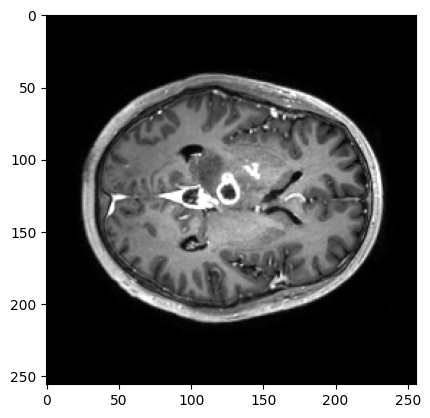

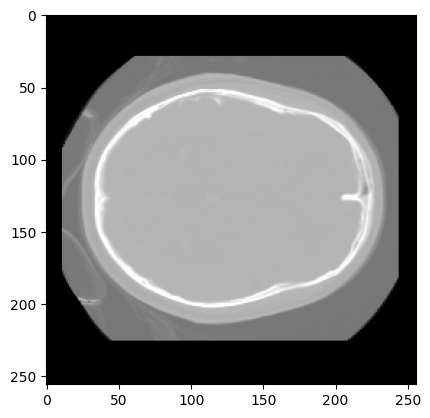

(256, 256)


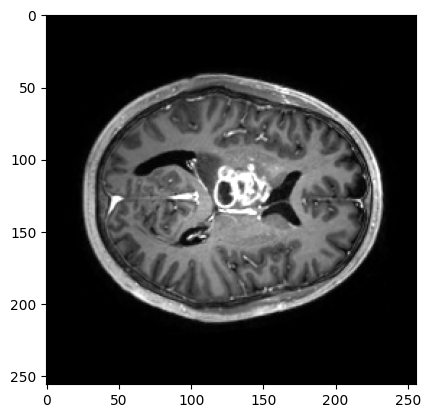

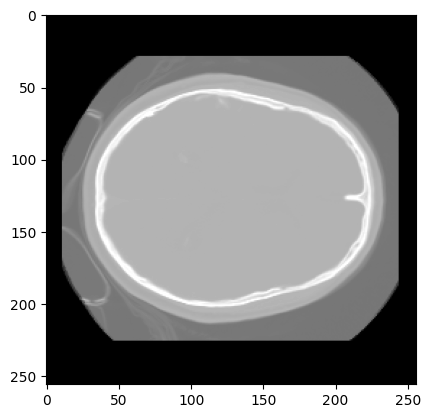

(256, 256)


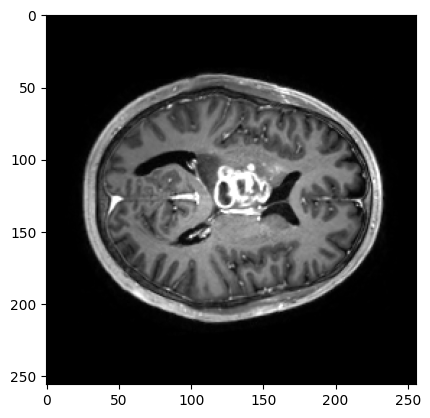

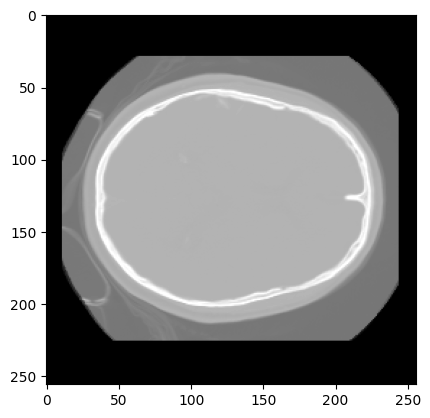

(256, 256)


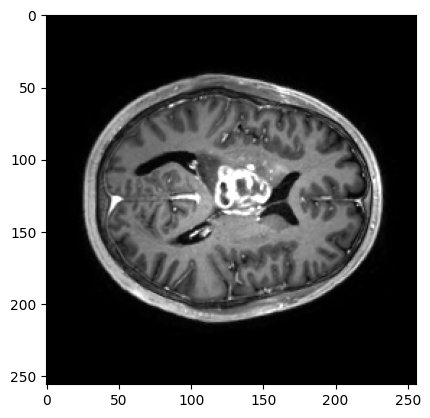

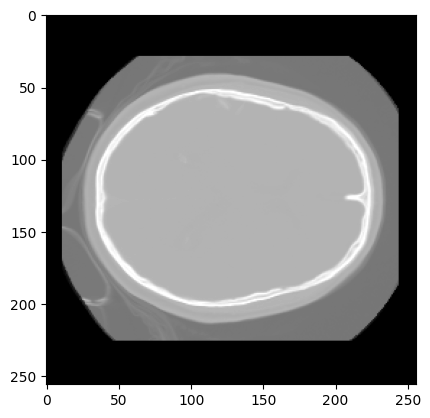

(256, 256)


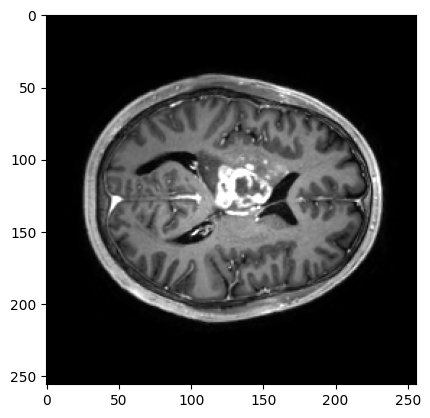

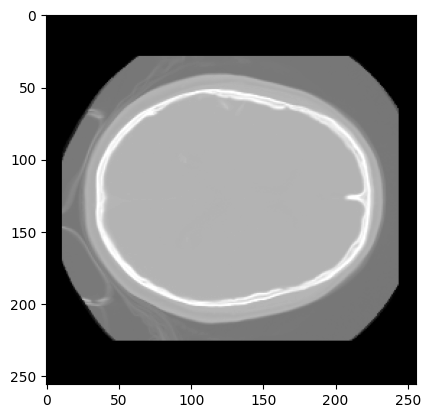

(256, 256)


In [4]:
# prompt: visualize the data above the data points are 2D images of size: size 65536

import matplotlib.pyplot as plt

# Assuming MRI_train contains 2D images of size 256x256
image_size = 256

for i in range(5):
  plt.imshow(MRI_train[i].reshape(image_size, image_size), cmap='gray')
  plt.show()
  plt.imshow(CT_train[i].reshape(image_size, image_size), cmap='gray')
  plt.show()
  print(CT_train[i].shape)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
# Tensorboard
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
# writer = SummaryWriter('runs/mri_ct_experiment')
writer = SummaryWriter("runs/no_sigmoid")

**Training**  
Adversarial Loss (Discriminator Loss):

Purpose: This loss measures how well the discriminators can distinguish between real and fake samples.
Indicator: A decreasing adversarial loss indicates that the generators are creating more realistic images that fool the discriminators.

Cycle Consistency Loss:

Purpose: This loss ensures that the mappings from one domain to another are consistent.
Indicator: A decreasing cycle consistency loss indicates that the generators are learning to generate images that are consistent when translated back and forth between the two domains.

Identity Loss (Optional):

Purpose: If included, identity loss ensures that the generators do not change the input image unnecessarily.
Indicator: A low identity loss indicates that the generators are preserving the input image structure when it belongs to the target domain.

Overall Generator Loss:

Purpose: This is the sum of the adversarial loss, cycle consistency loss, and identity loss (if used).
Indicator: Monitoring the overall generator loss provides an overview of how well the generators are performing across all aspects.

Discriminator Loss: The discriminator's goal is to distinguish between real and fake samples effectively, which translates to maximizing its loss function. The loss will therefore increase in magnitude and become negative

In [7]:
# Necessary Imports for training:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error
from gen_model import Generator
from dis_model import Discriminator
import torchvision
import sys
## Define generators and discriminators

# MRI images and CT scan images are grayscale therefore our input_channel = 1 and output_channel = 1 (With this kaggle dataset)
mri_channel = 1
ct_channel = 1

# Generators
generator_mri2ct = Generator(1, 1)
generator_ct2mri = Generator(ct_channel, mri_channel)

# Discriminators
discriminator_mri = Discriminator(mri_channel)
discriminator_ct = Discriminator(ct_channel)

# Define Optimizers *betas control the exponential decay rates*
optimizer_gen = torch.optim.Adam(list(generator_mri2ct.parameters()) + list(generator_ct2mri.parameters()), lr=1e-3, betas=(0.5, 0.999))
optimizer_dis_mri = torch.optim.Adam(list(discriminator_mri.parameters()) + list(discriminator_ct.parameters()), lr=1e-4, betas=(0.5, 0.999))
optimizer_dis_ct = torch.optim.Adam(list(discriminator_mri.parameters()) + list(discriminator_ct.parameters()), lr=1e-4, betas=(0.5, 0.999))


# Training Loop parameters
num_epochs = 30  # Adjust this based on experimentation
batch_size = 4  # Adjust this based on system's memory
lambda_cycle = 10  # Adjust this value based on experimentation
lambda_identity = 5  # If you use identity loss, adjust this as needed

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models and tensors to GPU
generator_mri2ct.to(device)
generator_ct2mri.to(device)
discriminator_mri.to(device)
discriminator_ct.to(device)
# Create data loader for training
dataset = list(zip(MRI_train, CT_train))  # Combine MRI_train and CT_train
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Criterion
criterion = nn.BCEWithLogitsLoss()
criterion_cycle = nn.SmoothL1Loss()
criterion_dis = nn.MSELoss()

# Identity Loss
use_identity_loss = False
loss_identity_ct = "NA"
loss_identity_mri = "NA"

num_batches = len(dataloader)
real_mri = None
fake_mri = None
real_ct = None
fake_ct = None

num_iters = 0

# Training Loop
for epoch in range(num_epochs):
    # Set models to training mode
    generator_mri2ct.train()
    generator_ct2mri.train()
    discriminator_mri.train()
    discriminator_ct.train()

    for i, (real_mri, real_ct) in enumerate(dataloader):
        real_mri = real_mri.to(device)
        real_ct = real_ct.to(device)

        real_mri = real_mri.float().unsqueeze(0)
        real_ct = real_ct.float().unsqueeze(0)


        # Reshaping Tensor to match the generator input shape
        real_mri = real_mri.permute(1, 0, 2, 3)
        real_ct = real_ct.permute(1, 0, 2, 3)

        # Generate fake images
        fake_ct = generator_mri2ct(real_mri)
        fake_mri = generator_ct2mri(real_ct)

        ### Discriminator Training ###
        optimizer_dis_mri.zero_grad()
        optimizer_dis_ct.zero_grad()

        # Compute discriminator losses for MRI and CT images
        # loss_dis_mri_real = discriminator_mri(real_mri).mean()
        loss_dis_mri_real = criterion_dis(real_mri, torch.ones_like(real_mri))
        # print(loss_dis_mri_real)
        # sys.exit(0)
        # loss_dis_mri_fake = discriminator_mri(fake_mri.detach()).mean()
        loss_dis_mri_fake = criterion_dis(fake_mri, torch.zeros_like(fake_mri))
        loss_dis_mri = loss_dis_mri_fake + loss_dis_mri_real

        # loss_dis_ct_real = discriminator_ct(real_ct).mean()
        loss_dis_ct_real = criterion_dis(real_ct, torch.ones_like(real_ct))
        # loss_dis_ct_fake = discriminator_ct(fake_ct.detach()).mean()
        loss_dis_ct_fake = criterion_dis(fake_ct, torch.zeros_like(fake_ct))
        loss_dis_ct = loss_dis_ct_fake + loss_dis_ct_real

        # Total discriminator loss
        loss_dis = (loss_dis_mri + loss_dis_ct) / 2

        # Backpropagation and optimizer step for discriminator
        loss_dis.backward(retain_graph=True)
        optimizer_dis_mri.step()
        optimizer_dis_ct.step()

        ### Generator Training ###
        optimizer_gen.zero_grad()

        # Adversarial losses for generators
        loss_gen_mri2ct_adv = criterion_dis(discriminator_ct(fake_ct), torch.ones_like(discriminator_ct(fake_ct)))
        loss_gen_ct2mri_adv = criterion_dis(discriminator_mri(fake_mri), torch.ones_like(discriminator_mri(fake_mri)))

        # Cycle consistency losses
        reconstructed_mri = generator_ct2mri(fake_ct)
        reconstructed_ct = generator_mri2ct(fake_mri)

        loss_cycle_mri = criterion_cycle(reconstructed_mri, real_mri)
        loss_cycle_ct = criterion_cycle(reconstructed_ct, real_ct)

        # Identity losses (optional)
        if use_identity_loss:
            identity_mri = generator_ct2mri(real_mri)
            identity_ct = generator_mri2ct(real_ct)

            loss_identity_mri = criterion_identity(identity_mri, real_mri)
            loss_identity_ct = criterion_identity(identity_ct, real_ct)

        # Total generator loss
        loss_gen = (loss_gen_mri2ct_adv + loss_gen_ct2mri_adv) + lambda_cycle * (loss_cycle_mri + loss_cycle_ct)
        if use_identity_loss:
            loss_gen += lambda_identity * (loss_identity_mri + loss_identity_ct)

        # Backpropagation and optimizer step for generator
        loss_gen.backward()
        optimizer_gen.step()

        # Print loss statistics
        if num_iters % 200 == 0:
            print('[%d/%d][%d/%d] Loss_D_MRI: %.4f Loss_D_CT: %.4f Loss_G_MRI2CT_adv: %.4f Loss_G_CT2MRI_adv: %.4f Loss_Cycle_MRI: %.4f Loss_Cycle_CT: %.4f' %
                  (epoch, num_epochs, i, len(dataloader), loss_dis_mri.item(), loss_dis_ct.item(), loss_gen_mri2ct_adv.item(), loss_gen_ct2mri_adv.item(), loss_cycle_mri.item(), loss_cycle_ct.item()))
            image_list = []
            print(real_mri.shape)
            if real_mri.shape[0] == batch_size:
                for j in range(batch_size):
                    # Create grid of real MRI, CT, fake CT, fake MRI in one row, and write for all j
                    image_list.extend([real_mri[j], real_ct[j], fake_mri[j], fake_ct[j]])
                grid = torchvision.utils.make_grid(image_list, nrow=4, padding=2, normalize=True)
                writer.add_image('MRI2CT', grid, num_iters)

        num_iters += 1


[0/30][0/38] Loss_D_MRI: 1.1009 Loss_D_CT: 0.9082 Loss_G_MRI2CT_adv: 0.9060 Loss_G_CT2MRI_adv: 1.0329 Loss_Cycle_MRI: 0.1277 Loss_Cycle_CT: 0.1060
torch.Size([4, 1, 256, 256])
[5/30][10/38] Loss_D_MRI: 1.0087 Loss_D_CT: 0.9894 Loss_G_MRI2CT_adv: 0.8118 Loss_G_CT2MRI_adv: 0.9211 Loss_Cycle_MRI: 0.0028 Loss_Cycle_CT: 0.0011
torch.Size([4, 1, 256, 256])
[10/30][20/38] Loss_D_MRI: 0.9919 Loss_D_CT: 1.0086 Loss_G_MRI2CT_adv: 0.8009 Loss_G_CT2MRI_adv: 0.9172 Loss_Cycle_MRI: 0.0015 Loss_Cycle_CT: 0.0004
torch.Size([4, 1, 256, 256])
[15/30][30/38] Loss_D_MRI: 1.0154 Loss_D_CT: 1.0166 Loss_G_MRI2CT_adv: 0.7985 Loss_G_CT2MRI_adv: 0.9128 Loss_Cycle_MRI: 0.0006 Loss_Cycle_CT: 0.0003
torch.Size([4, 1, 256, 256])
[21/30][2/38] Loss_D_MRI: 0.9071 Loss_D_CT: 0.9959 Loss_G_MRI2CT_adv: 0.8115 Loss_G_CT2MRI_adv: 0.9488 Loss_Cycle_MRI: 0.0025 Loss_Cycle_CT: 0.0008
torch.Size([4, 1, 256, 256])
[26/30][12/38] Loss_D_MRI: 0.9208 Loss_D_CT: 0.8677 Loss_G_MRI2CT_adv: 0.8529 Loss_G_CT2MRI_adv: 0.9510 Loss_Cycle

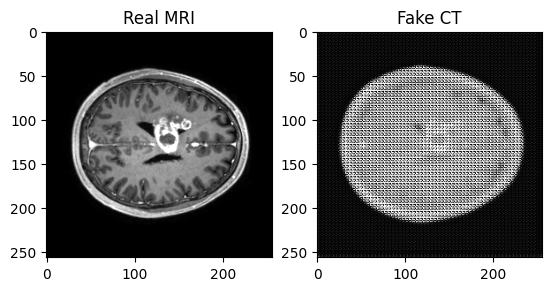

In [8]:
# Test mri2ct generator
generator_mri2ct.eval()
generator_ct2mri.eval()

# Test the generator

# Load a batch of MRI images
real_mri = MRI_train[20]
real_mri = torch.tensor(real_mri).to(device)
real_mri = real_mri.float().unsqueeze(0).unsqueeze(0)

# Generate fake CT images
fake_ct = generator_mri2ct(real_mri)

# Normalize the fake CT images
fake_ct = (fake_ct - fake_ct.min()) / (fake_ct.max() - fake_ct.min())

# Plot real MRI and fake CT images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(real_mri.cpu().detach().numpy().reshape(image_size, image_size), cmap='gray')
plt.title('Real MRI')
plt.subplot(1, 2, 2)
plt.imshow(fake_ct.cpu().detach().numpy().reshape(image_size, image_size), cmap='gray')
plt.title('Fake CT')
plt.show()

Text(0.5, 1.0, 'Fake MRI')

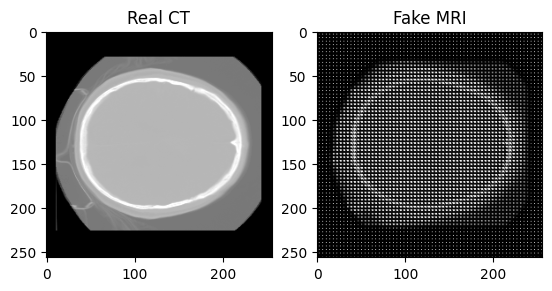

In [9]:
# Show real CT and fake MRI images
# Load a batch of CT images
real_ct = CT_train[20]
real_ct = torch.tensor(real_ct).to(device)
real_ct = real_ct.float().unsqueeze(0).unsqueeze(0)

# Generate fake MRI images
fake_mri = generator_ct2mri(real_ct)

# Normalize the fake MRI images
fake_mri = (fake_mri - fake_mri.min()) / (fake_mri.max() - fake_mri.min())

# Plot real CT and fake MRI images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(real_ct.cpu().detach().numpy().reshape(image_size, image_size), cmap='gray')
plt.title('Real CT')
plt.subplot(1, 2, 2)
plt.imshow(fake_mri.cpu().detach().numpy().reshape(image_size, image_size), cmap='gray')
plt.title('Fake MRI')